### 1. Graph based segmentation (grid) version 1

This is graph based segmentation implementation version 1.

- This algorithm is very slow, because every time `D()` is called, `MST()` is called.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in ubyte_scalars


  0%|          | 0/7812 [00:00<?, ?it/s]

Done. # group = 52


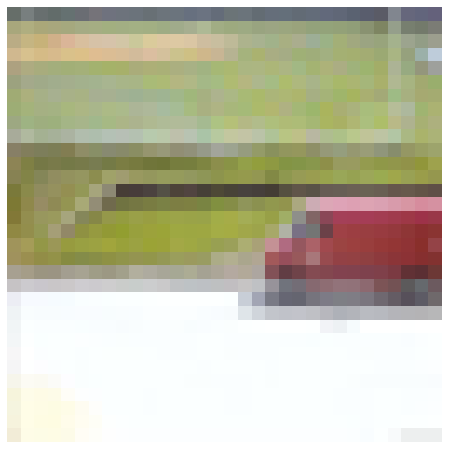

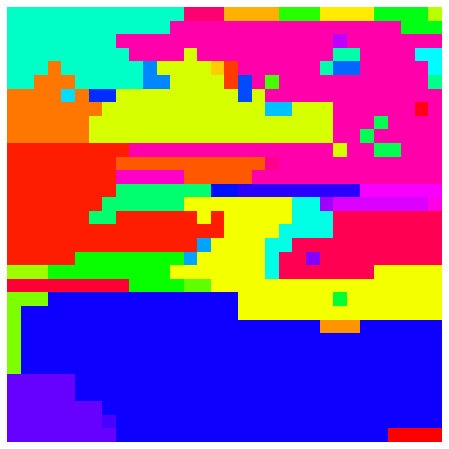

In [30]:
import math
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 


def show_img(img):
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


def load_img(path):
    return np.asarray(Image.open(path).resize((32, 32), Image.BICUBIC))


def get_cmap(n, name='hsv'):
    cmap = plt.cm.get_cmap(name, n)
    return [cmap(i)[:3] for i in range(n)]


def fill_color(group, H, W):
    group_color = get_cmap(len(list(set(group))))
    segmented = np.zeros([H, W, 3])
    for i, c in enumerate(group):
        h, w = divmod(i, W)
        segmented[h][w] = group_color[c]
    
    return segmented


class Edge:
    def __init__(self, v1, v2, p1, p2, H, W):
        self.v1 = v1
        self.v2 = v2
        self.p1 = p1
        self.p2 = p2
        self.H = H
        self.W = W
        self.weight = self.compute_weight()

    @property
    def v1_id(self):
        return self.v1[0] * self.W + self.v1[1]

    @property
    def v2_id(self):
        return self.v2[0] * self.W + self.v2[1]
    
    def compute_weight(self):
        return math.sqrt(sum([pow(i - j, 2) for i, j in zip(self.p1, self.p2)]))

    def __repr__(self):
        return f"(i={self.v1}, j={self.v2}, w={self.weight})"


def init_graph(img):
    """initialize graph by building edge and weight

    return graph, sorted edge list
    """
    H, W, C = img.shape
    grid = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
    graph = []
    edge_list = []

    for h in range(H):
        for w in range(W):
            neighbor = []
            for dr, dc in grid:
                n_h = h + dr
                n_w = w + dc
                if 0 <= n_h < H and 0 <= n_w < W:
                    edge = Edge((h, w), (n_h, n_w), img[h, w], img[n_h, n_w], H, W) 
                    neighbor.append(edge)  
                    edge_list.append(edge)
            graph.append(neighbor)

    edge_list.sort(key=lambda x: x.weight, reverse=False)

    return graph, edge_list


def Diff(v1, v2, graph, segment, group_id):
    """return minimum weight of edge connecting v1 and v1"""
    seg1_vertex_list = segment[group_id[v1]]
    seg2_vertex_list = segment[group_id[v2]]
    seg1toseg2_edge_weight_list = [edge.weight for v in seg1_vertex_list for edge in graph[v] if edge.v2_id in seg2_vertex_list]
    seg2toseg1_edge_weight_list = [edge.weight for v in seg2_vertex_list for edge in graph[v] if edge.v2_id in seg1_vertex_list]

    diff =  min(seg1toseg2_edge_weight_list + seg2toseg1_edge_weight_list)

    return diff


def Union_find(idx, parents):
    if idx == parents[idx]:
        return idx
    
    parents[idx] = Union_find(parents[idx], parents)
    return parents[idx]
    

def Union_join(i, j, parents):
    p_i = parents[i]
    p_j = parents[j]

    if p_i < p_j:
        parents[p_j] = p_i
    else:
        parents[p_i] = p_j


def MST(vertex_list, edge_list):
    """Minimum Spanning Tree"""
    u = list(range(len(vertex_list)))
    id2idx = {id:idx for idx, id in enumerate(vertex_list)}
    edge_list = [(id2idx[edge.v1_id], id2idx[edge.v2_id], edge.weight) for edge in edge_list]
    edge_list.sort(key=lambda x : x[2], reverse=False)

    weight_list = [0]

    for start, end, weight in edge_list:
        if Union_find(start, u) != Union_find(end, u):
            Union_join(start, end, u)
            weight_list.append(weight)

    return weight_list

def Inc(v, graph, segment, group_id):
    """return maximum weight of edge in mst of segment selected by v"""
    vertex_list = segment[group_id[v]] # 0, 1, 2, 3, 4, 5
    edge_list = [edge for v in vertex_list for edge in graph[v] if edge.v2_id in vertex_list]
    
    weight_list = MST(vertex_list, edge_list)
    inc = max(weight_list)

    return inc


def Tau(v, segment, group_id, K=300):
    """Give penalty for smaller component"""
    return K / len(segment[group_id[v]])


def MInc(v1, v2, graph, segment, group_id, K):
    """Compare internal difference of v1 and v2"""
    return min(Inc(v1, graph, segment, group_id) + Tau(v1, segment, group_id, K), Inc(v2, graph, segment, group_id) + Tau(v2, segment, group_id, K))


def D(v1, v2, graph, segment, group_id, K):
    """Return True if boundary should be exist"""
    if Diff(v1, v2, graph, segment, group_id) > MInc(v1, v2, graph, segment, group_id, K):
        return True
    else:
        return False


def merge_segment(v1, v2, segment, group_id):
    g1 = group_id[v1]
    g2 = group_id[v2]
    g_new = len(segment)
    segment.append(segment[g1] + segment[g2])
    for v_id in segment[g_new]:
        group_id[v_id] = g_new


def segment_img(img, K=300):
    H, W, C = img.shape
    graph, edge_list = init_graph(img)
    segment = [[r * W + c] for r in range(H) for c in range(W)]
    group_id = [i for i in range(H * W)]

    for edge in tqdm(edge_list):
        v1 = edge.v1_id
        v2 = edge.v2_id
        if group_id[v1] != group_id[v2]:
            if not D(v1, v2, graph, segment, group_id, K):
                merge_segment(v1, v2, segment, group_id)

    num_group = len(list(set(group_id)))
    id2idx = {id:idx for idx, id in enumerate(list(set(group_id)))}
    group_id = [id2idx[id] for id in group_id]
    print(f"Done. # group = {num_group}")

    segmented = fill_color(group_id, H, W)

    return segmented


img = load_img('sample_imgs/car.jpg')
segmented = segment_img(img)
show_img(img)
show_img(segmented)

### 2. Graph based segmentation (grid) version 2.

Updates:
1. check if two pixels are same segments(find) and join two different segments(join) is done via Disjoin operation. 
2. Add post processing steps
3. Track mst and size of each components (speed up)
4. (important) apply guassian smoothing suggested in original code, not regular one

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in ubyte_scalars


  0%|          | 0/1969756 [00:00<?, ?it/s]

  0%|          | 0/1969756 [00:00<?, ?it/s]

Done. # group = 578


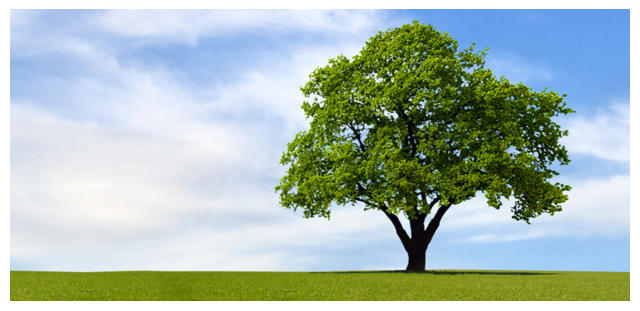

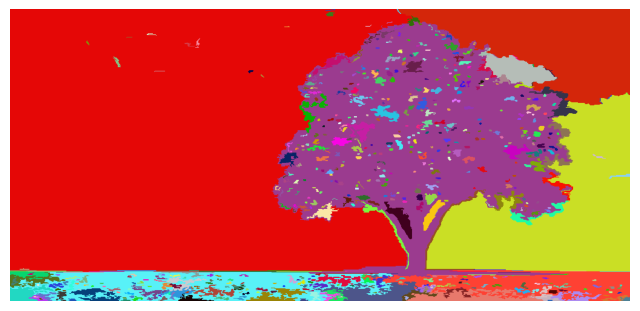

In [19]:
import os
import math
import time
import random
from PIL import Image

from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 


random.seed(1)
WIDTH = 4.0

def show_img(img, save_name=None, dpi=100):
    plt.figure(figsize=(8, 8), dpi=dpi)
    plt.imshow(img)
    plt.axis('off')
    if save_name:
        plt.savefig(os.path.join('2_pegbis', f'{save_name}.jpg'))
        plt.show()
    else:
        plt.show()


def load_img(path):
    return np.asarray(Image.open(path))


def convolve_even(src, mask):
    """Convolution(2D) with src image and mask kernel"""
    output = np.zeros(shape=src.shape, dtype=float)
    height, width = src.shape
    length = len(mask)

    for y in range(height):
        for x in range(width):
            sum = float(mask[0] * src[y, x])
            for i in range(1, length):
                sum += mask[i] * (src[y, max(x - i, 0)] + src[y, min(x + i, width - 1)])
            output[y, x] = sum
    return output


def normalize(mask):
    """Normalized ndarray by sum"""
    sum = 2 * np.sum(np.absolute(mask)) + abs(mask[0])
    return np.divide(mask, sum)


def make_fgauss(sigma):
    sigma = max(sigma, 0.01)
    length = int(math.ceil(sigma * WIDTH)) + 1
    mask = np.zeros(shape=length, dtype=float)
    for i in range(length):
        mask[i] = math.exp(-0.5 * math.pow(i / sigma, i / sigma))
    return mask


def smooth(src, sigma):
    """Guassian Filter function for 1 channel"""
    mask = make_fgauss(sigma)
    mask = normalize(mask)
    tmp = convolve_even(src, mask)
    dst = convolve_even(tmp, mask)
    return dst


def apply_guassian(img, sigma):
    """Apply 1D gaussian smoothing

    This module is copied from https://github.com/salaee/pegbis.
    I tried to replace this function with other library, but failed.
    Guassian filter is always the most important function in segmentation.

    args:
        img(ndarray): image array (uint8)
        sigma(float): smoothing kernel size (higher, smoother)

    return:
        smoothend image
    """
    gaussian_img = np.zeros(img.shape, dtype=float)
    gaussian_img[:, :, 0] = smooth(img[:, :, 0], sigma)
    gaussian_img[:, :, 1] = smooth(img[:, :, 1], sigma)
    gaussian_img[:, :, 2] = smooth(img[:, :, 2], sigma)
    return gaussian_img
    # return gaussian_filter(img.astype(float), sigma)



def get_cmap(n, name='hsv'):
    cmap = [[random.random() for _ in range(3)] for i in range(n)]
    return cmap


def fill_color(group, H, W):
    group_color = get_cmap(len(list(set(group))))
    segmented = np.zeros([H, W, 3])
    for i, c in enumerate(group):
        h, w = divmod(i, W)
        segmented[h][w] = group_color[c]
    
    return segmented


class Edge:
    def __init__(self, v1, v2, p1, p2, H, W):
        self.v1 = v1
        self.v2 = v2
        self.p1 = p1
        self.p2 = p2
        self.H = H
        self.W = W
        self.weight = self.compute_weight()

    @property
    def v1_id(self):
        return self.v1[0] * self.W + self.v1[1]

    @property
    def v2_id(self):
        return self.v2[0] * self.W + self.v2[1]
    
    def compute_weight(self):
        return math.sqrt(sum([(i-j) * (i-j) for i, j in zip(list(self.p1), list(self.p2))]))
        # return math.sqrt(sum([pow((i-j), 2) for i, j in zip(list(self.p1), list(self.p2))]))

    def __repr__(self):
        return f"(i={self.v1}, j={self.v2}, w={self.weight})"


def init_graph(img):
    """initialize graph by building edge and weight

    return sorted edge list
    """
    H, W, C = img.shape
    grid = [(-1, 1), (0, 1), (1, 0), (1, 1)]
    edge_list = []

    for h in range(H):
        for w in range(W):
            for dr, dc in grid:
                n_h = h + dr
                n_w = w + dc
                if (0 <= n_h < H) and (0 <= n_w < W):
                    edge = Edge((h, w), (n_h, n_w), img[h, w], img[n_h, n_w], H, W) 
                    edge_list.append(edge)

    edge_list.sort(key=lambda x: x.weight, reverse=False)

    return edge_list


def Union_find(idx, parents):
    if idx == parents[idx]:
        return idx
    
    parents[idx] = Union_find(parents[idx], parents)
    return parents[idx]
    

def Union_join(i, j, weight, parents, threshold, size, rank, K):
    p_i = Union_find(i, parents)
    p_j = Union_find(j, parents)

    if rank[p_i] < rank[p_j]:
        parents[p_i] = p_j
        size[p_j] += size[p_i]
        threshold[p_j] = weight + K / size[p_j]
    else:
        parents[p_j] = p_i
        size[p_i] += size[p_j]
        threshold[p_i] = weight + K / size[p_i]
        if rank[p_i] == rank[p_j]:
            rank[p_i] += 1


def MInc(v1, v2, mst, size, K):
    """Compare internal difference of v1 and v2"""
    return min(mst[v1] + K / size[v1], mst[v2] + K / size[v2])


def D(v1, v2, weight, mst, size, K):
    """Return True if boundary should be exist"""
    if weight <= MInc(v1, v2, mst, size, K):
        return True


def segment_img(img, K=300, min_size=50):
    H, W, C = img.shape

    # 1. make grid graph
    edge_list = init_graph(img)
    group_id = list(range(H * W)) 
    threshold = [K for _ in range(H * W)]
    size = [1 for _ in range(H * W)]
    rank = [0 for _ in range(H * W)]

    # 2. connect pixel by relative internal difference
    for edge in tqdm(edge_list):
        c1 = Union_find(edge.v1_id, group_id)
        c2 = Union_find(edge.v2_id, group_id)
        if c1 != c2:
            if edge.weight < min(threshold[c1], threshold[c2]):
                Union_join(c1, c2, edge.weight, group_id, threshold, size, rank, K)

    # 3. connect region smaller than min_size (post process, only shown in the code)
    for edge in tqdm(edge_list):
        c1 = Union_find(edge.v1_id, group_id)
        c2 = Union_find(edge.v2_id, group_id)
        if c1 != c2 and (size[c1] < min_size or size[c2] < min_size):
            Union_join(c1, c2, edge.weight, group_id, threshold, size, rank, K)

    # 4. Refind parents
    for i in range(H * W):
        Union_find(i, group_id)

    # 5. show results
    id2idx = {id:idx for idx, id in enumerate(list(set(group_id)))}
    group_id = [id2idx[id] for id in group_id]
    segmented = fill_color(group_id, H, W)
    print(f"Done. # group = {len(list(set(group_id)))}")

    return segmented


image_name_list=['paris', 'BigTree']
image_name_list2=['car', 'baseball']

# Todo List
# 1. Current `init_graph()` is too slow due to making new class instance
# 2. `apply_gaussian()` should be applied differently for each image due to smoothness effects

for img_name in image_name_list:
    img = load_img(f'sample_imgs/{img_name}.jpg')
    gaussian_img = apply_guassian(img, sigma=0.8)
    segmented = segment_img(gaussian_img, K=300, min_size=10)
    show_img(img, dpi=100)
    show_img(segmented, dpi=100)